## I&I

In [ ]:
# research of som etechniques/ libraries
# https://github.com/seninp/saxpy

In [3]:
import os,sys
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)  # To find local version of the library

In [4]:

import numpy as np
import pandas as pd
import pylab as pl

%pylab inline --no-import-all

import pandas as pd
import numpy as np
import glob
from collections import Counter
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sb
import datetime
import itertools

from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix as cm

% matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# add auto relaod
%load_ext autoreload
% autoreload 2
from utils import *
from detect_peaks import detect_peaks
    
from sklearn_porter import Porter

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['../data/Acc_Data_0805.xlsx']
Acc_Data_0805.xlsx Regular
Driving
Acc_Data_0805.xlsx Bumper1
Bumper
Acc_Data_0805.xlsx Bumper2
Bumper
Acc_Data_0805.xlsx Zigzag1
Zigzag
Acc_Data_0805.xlsx Zigzag2
Zigzag
Acc_Data_0805.xlsx Zigzag3
Zigzag
['../data/Acc_Data_Tow_1605.xlsx']
Acc_Data_Tow_1605.xlsx Tow_Chevrolet1
Tow
Acc_Data_Tow_1605.xlsx Tow_Chevrolet2
Tow
Acc_Data_Tow_1605.xlsx Tow_Chevrolet3
Tow
Acc_Data_Tow_1605.xlsx Tow_Chevrolet1_Back
Tow
Acc_Data_Tow_1605.xlsx Tow_Chevrolet2_Back
Tow
Acc_Data_Tow_1605.xlsx Tow_Chevrolet3_Back
Tow
Acc_Data_Tow_1605.xlsx Tow_Nissan1
Tow
Acc_Data_Tow_1605.xlsx Tow_Nissan2
Tow
Acc_Data_Tow_1605.xlsx Tow_Nissan3
Tow
Acc_Data_Tow_1605.xlsx Tow_Nissan1_Back
Tow
Acc_Data_Tow_1605.xlsx Tow_Nissan2_Back
Tow
Acc_Data_Tow_1605.xlsx Tow_Nissan3_Back
Tow
Acc_Data_Tow_1605.xlsx Tow_Toyota1
Tow
Acc_Data_Tow_1605.xlsx Tow_Toyota2
Tow
Acc_Data_Tow_1605.xlsx Tow_Toyota3
Tow
Acc_Data_Tow_1605.xlsx Tow_Toyota1_Back
Tow
Acc_Data_Tow_1605.xlsx Tow_Toyota2_Back
Tow
Acc_Data

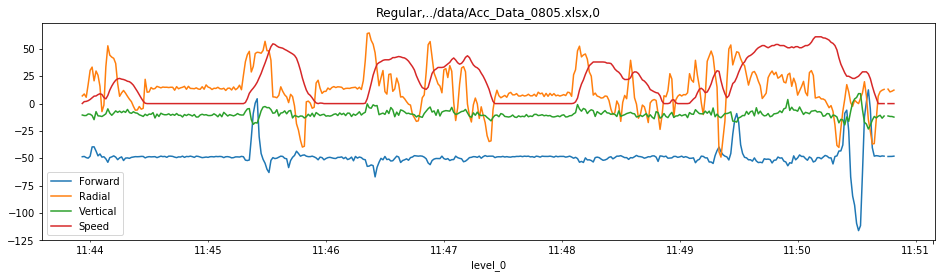

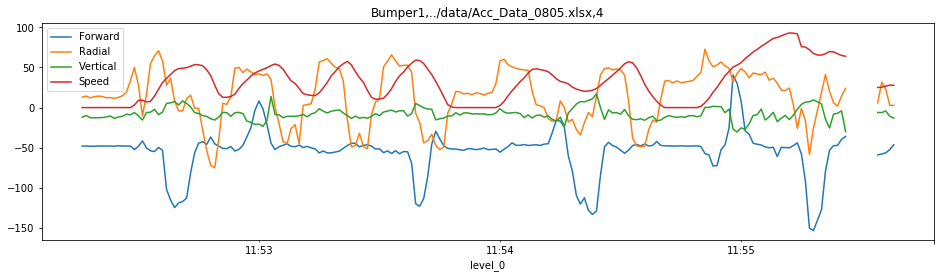

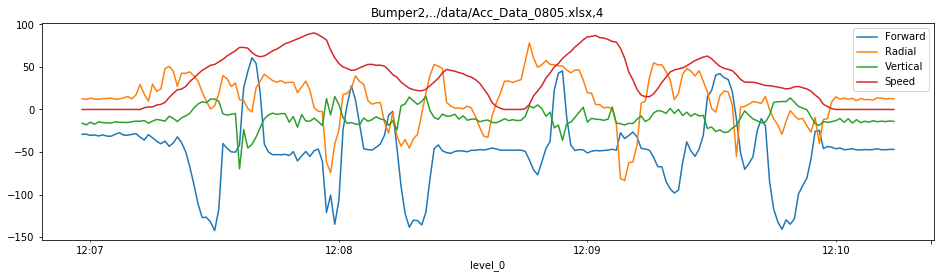

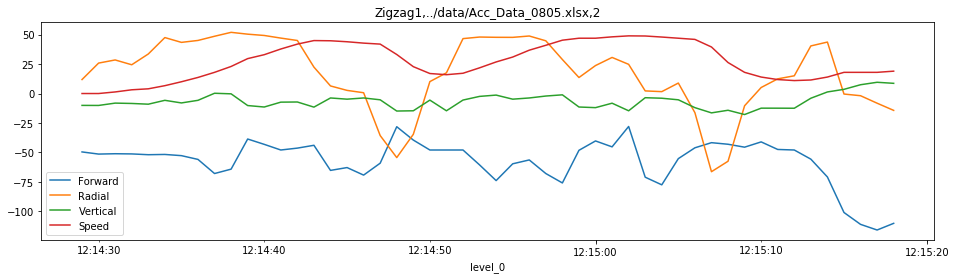

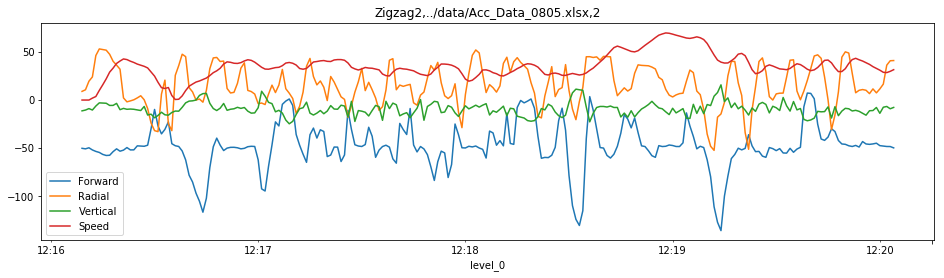

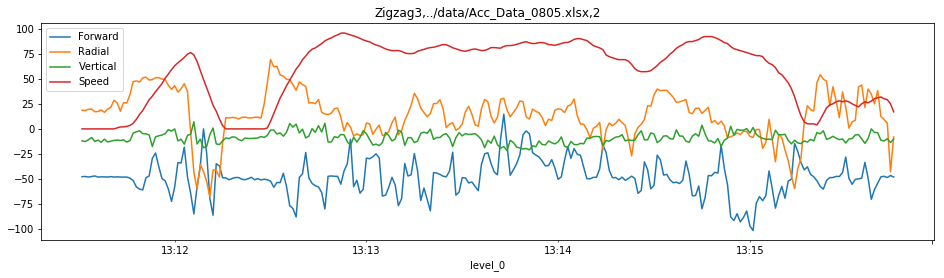

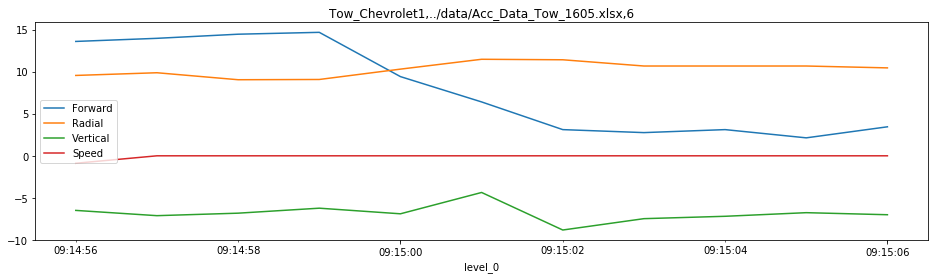

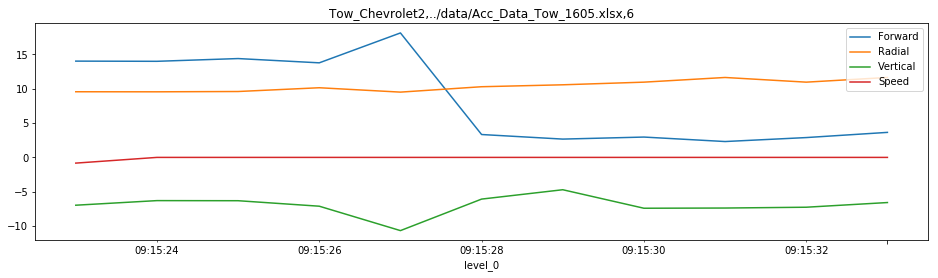

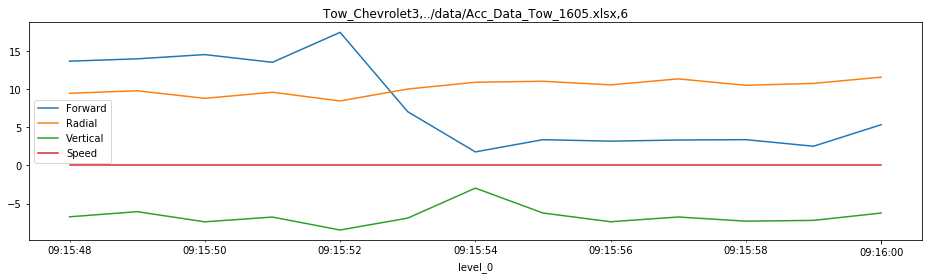

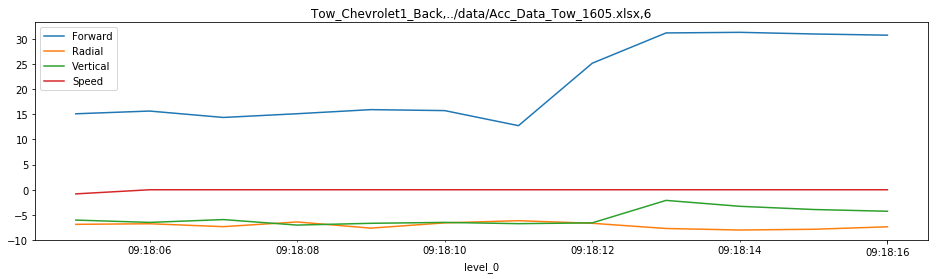

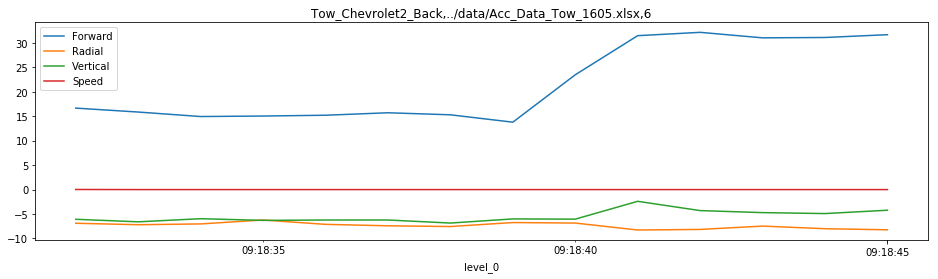

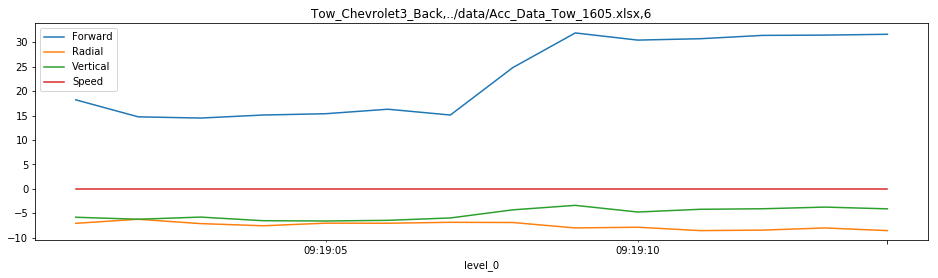

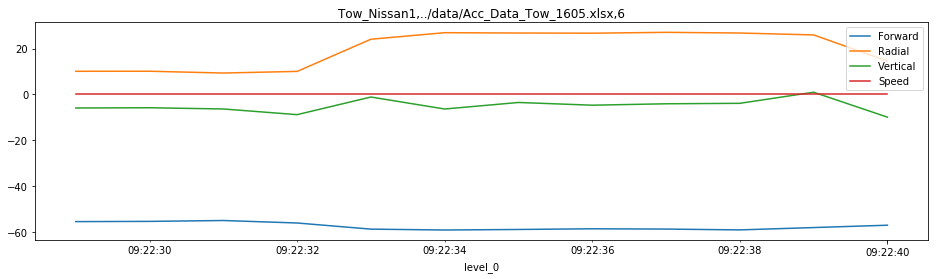

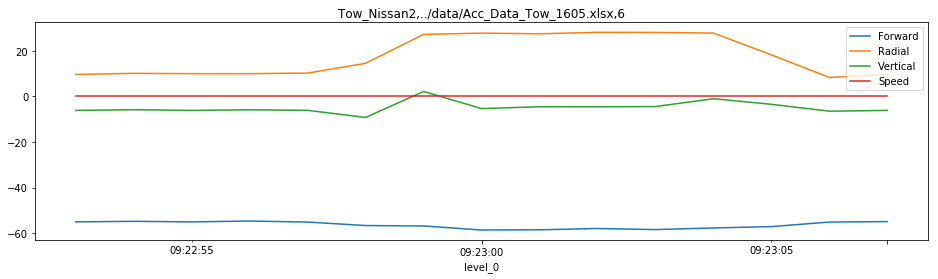

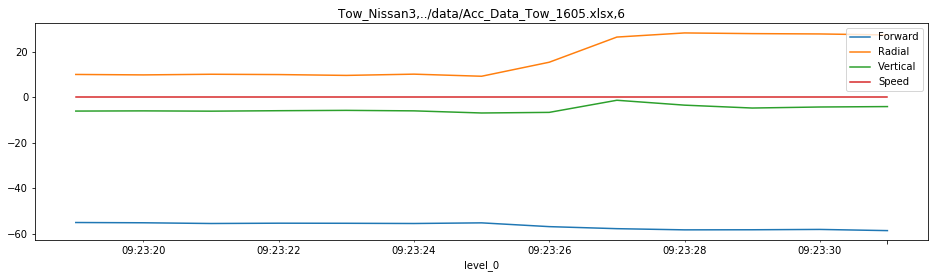

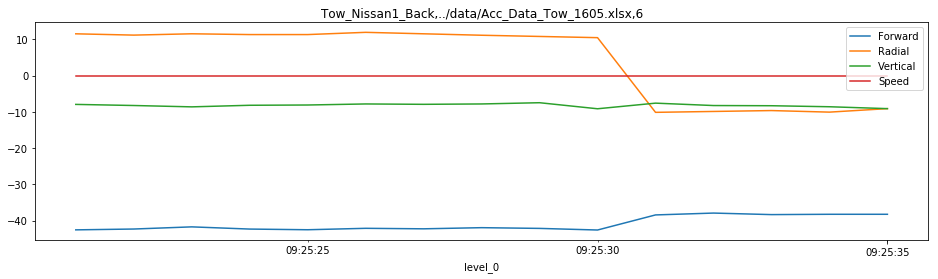

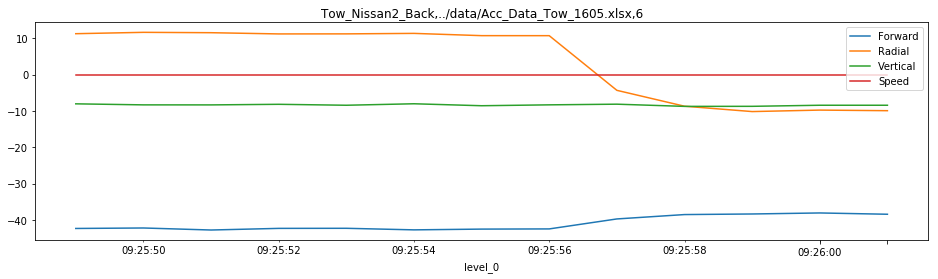

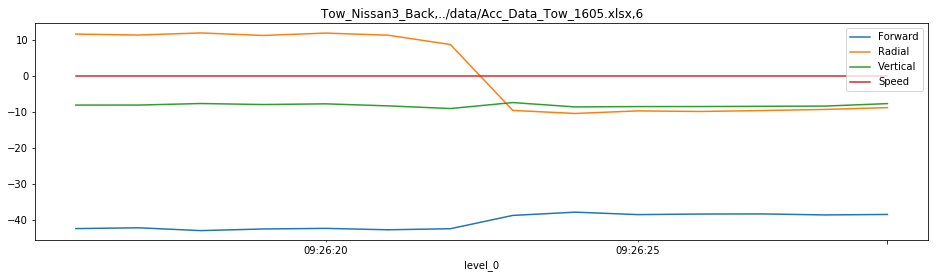

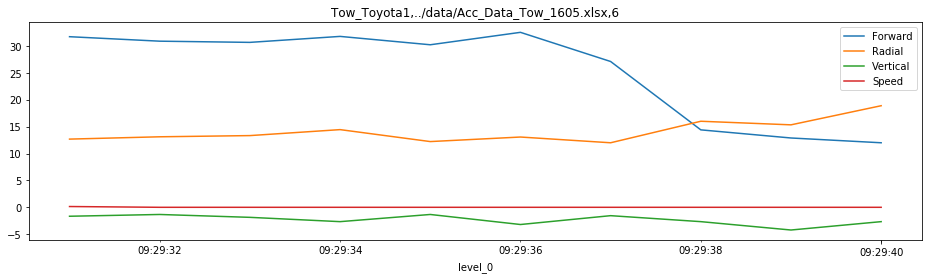

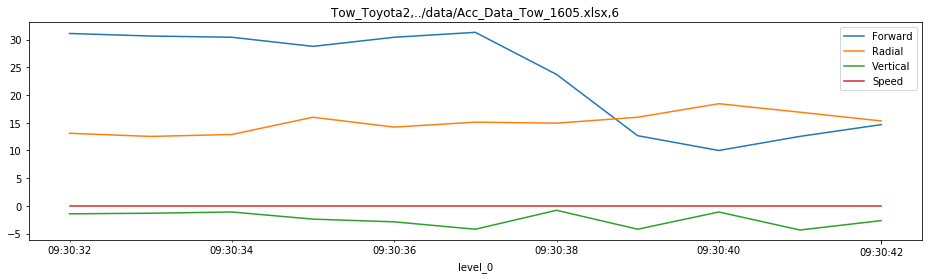

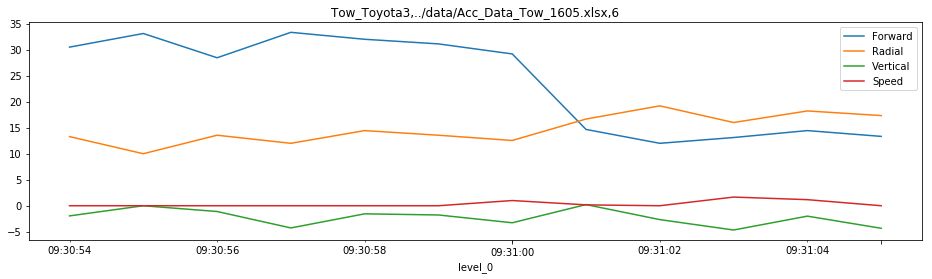

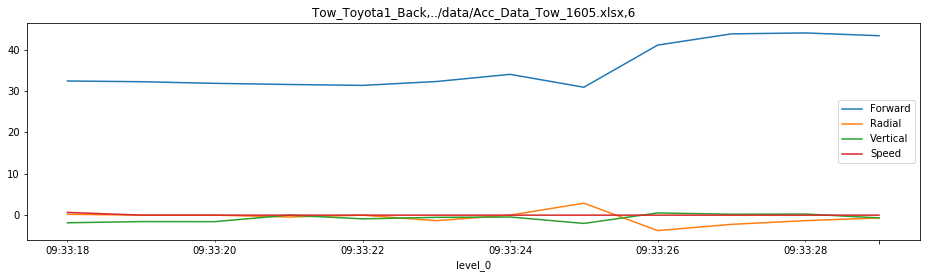

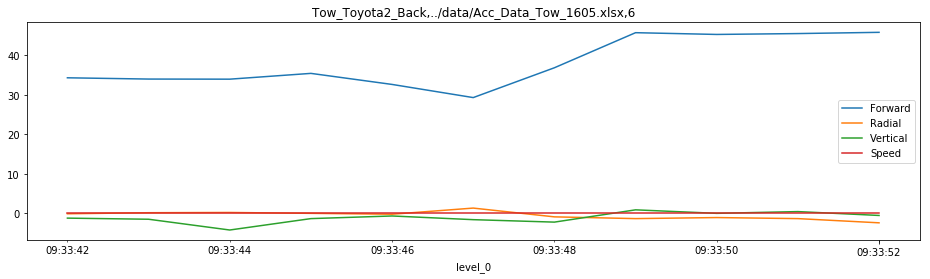

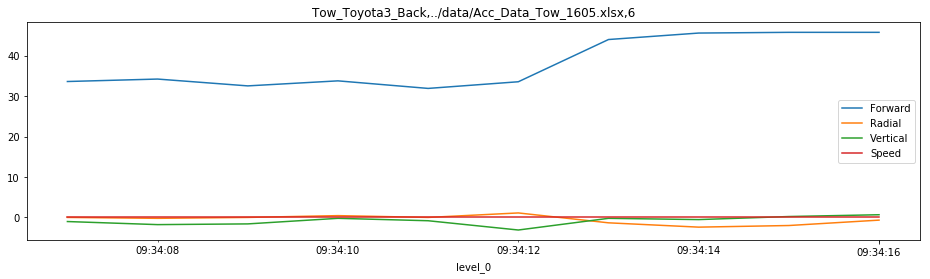

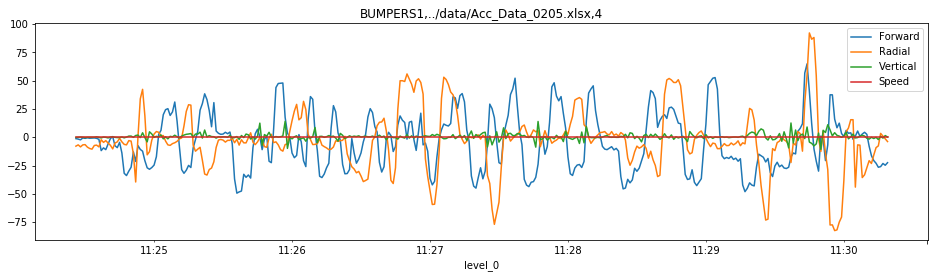

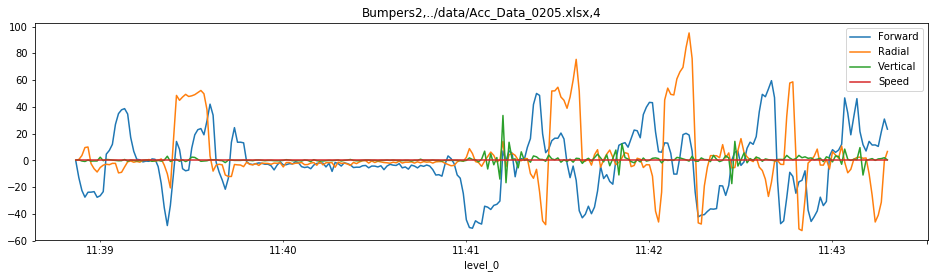

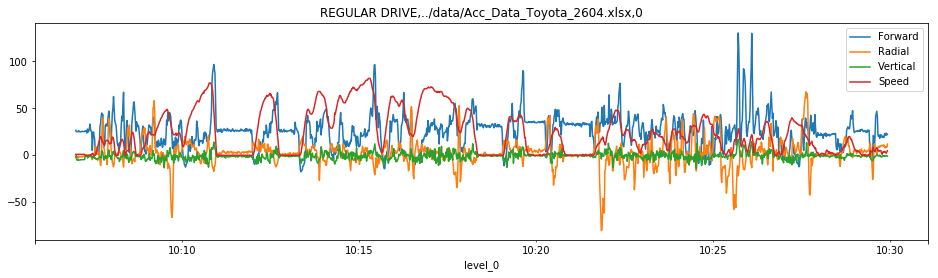

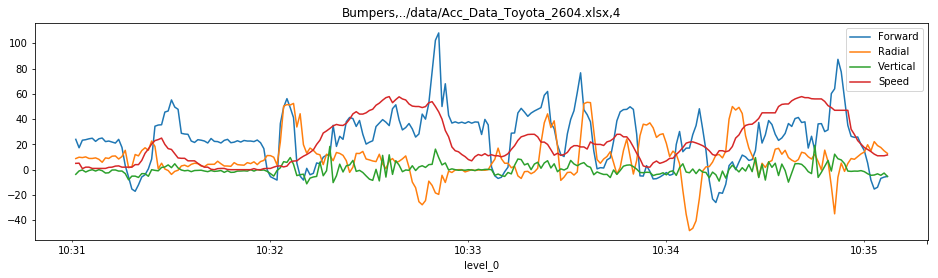

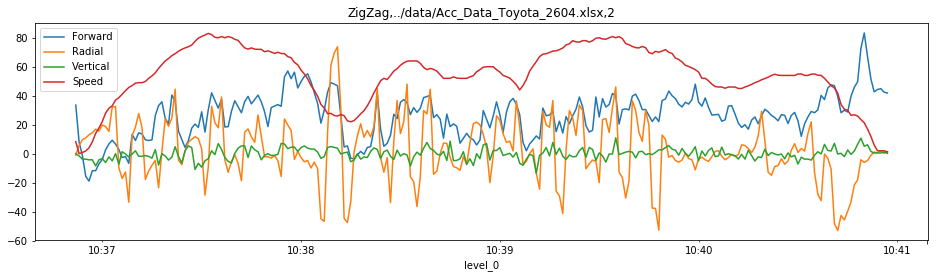

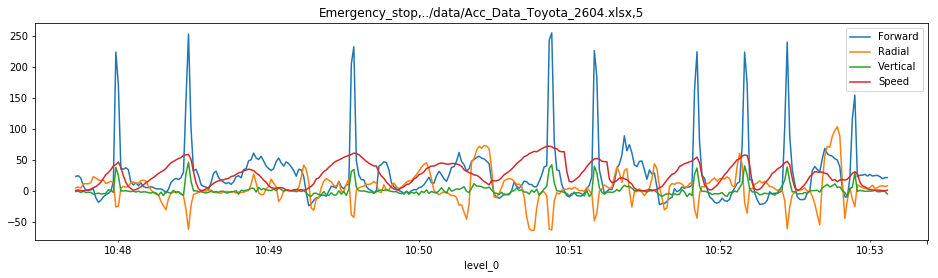

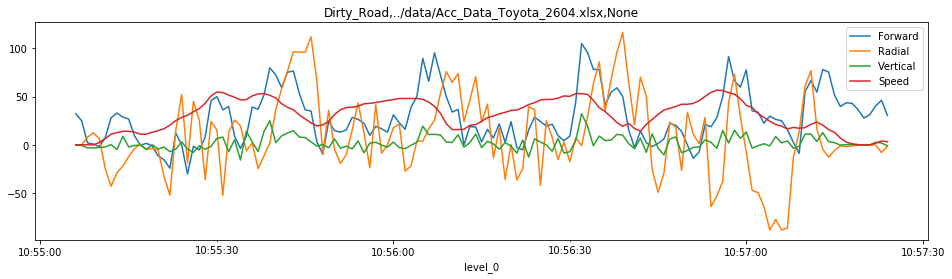

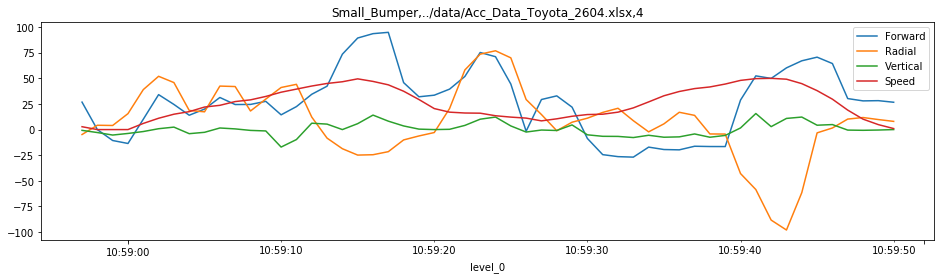

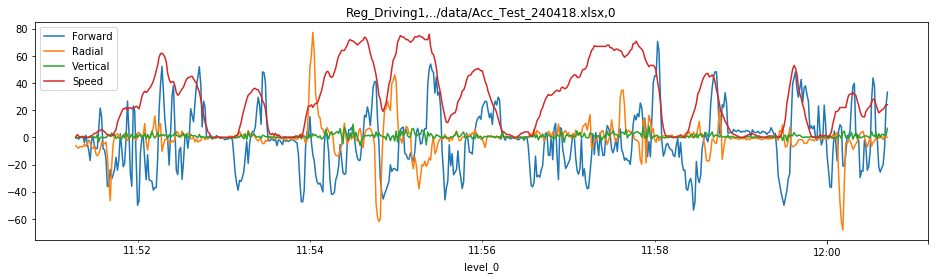

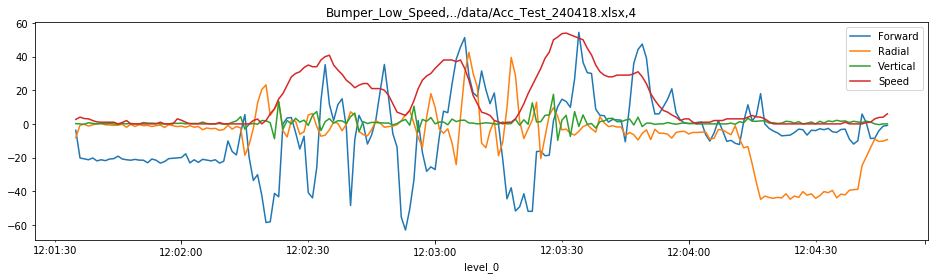

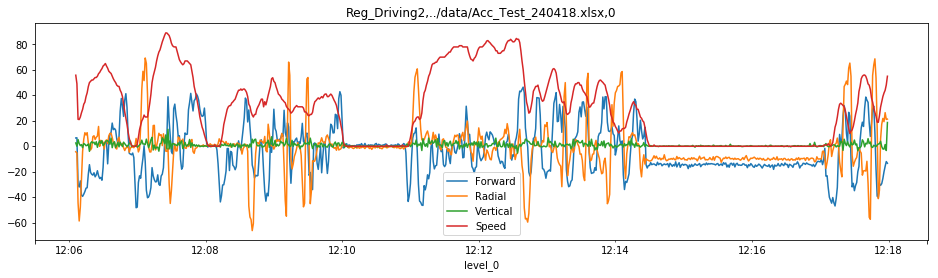

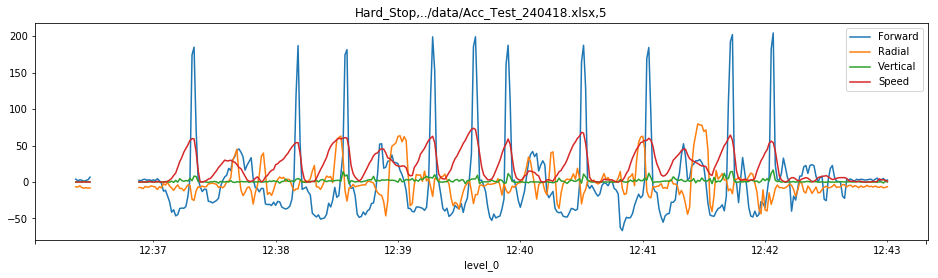

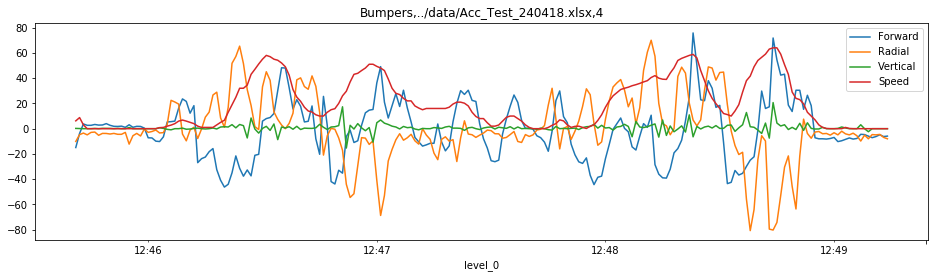

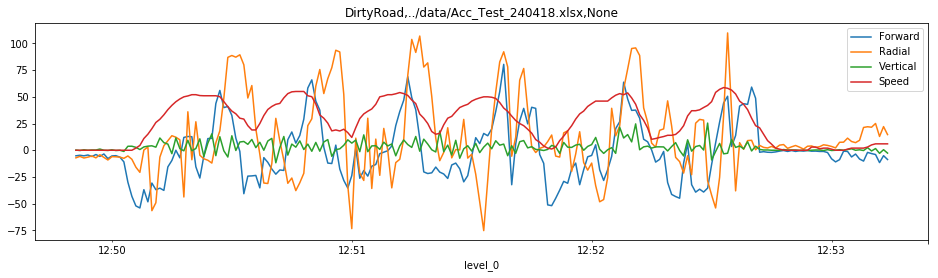

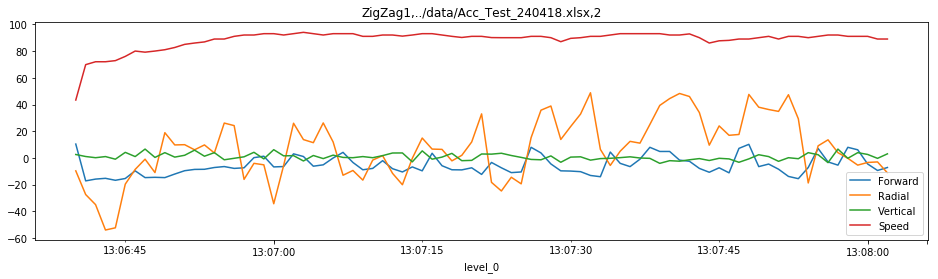

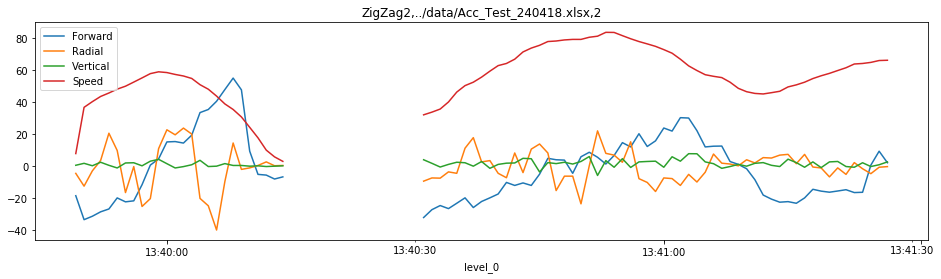

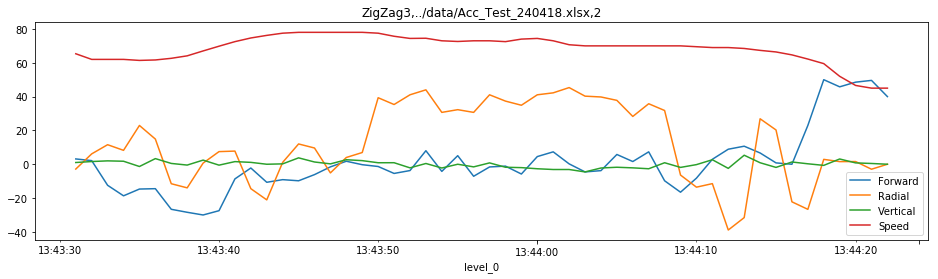

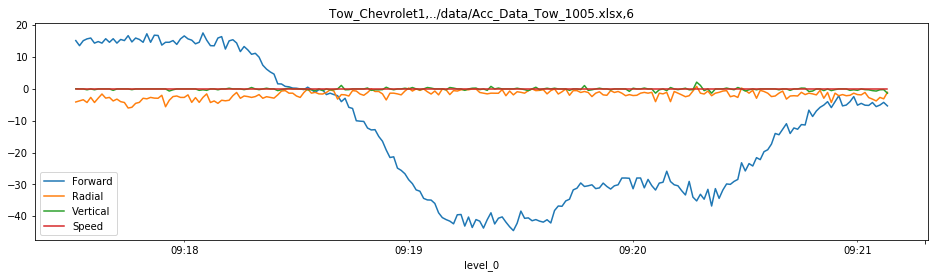

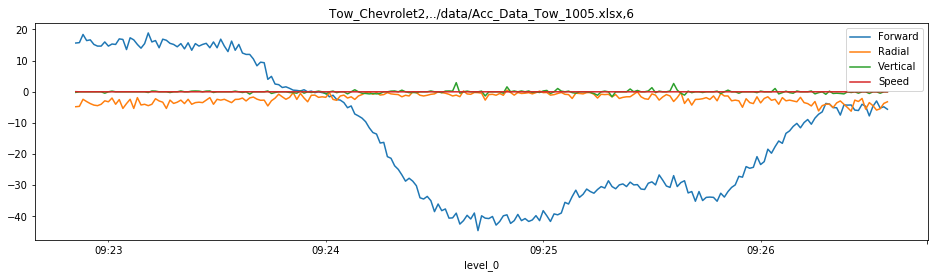

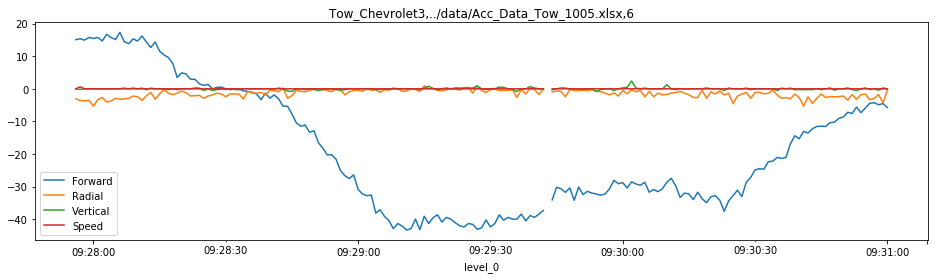

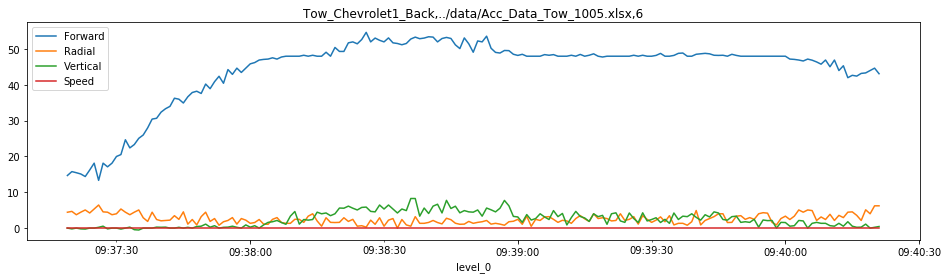

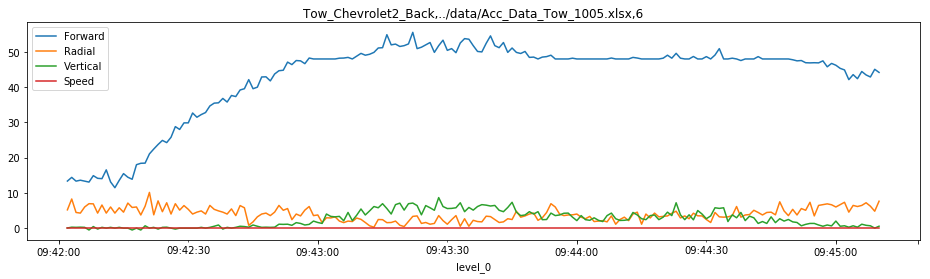

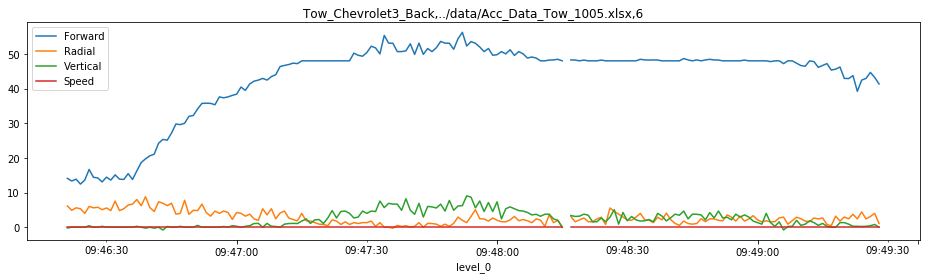

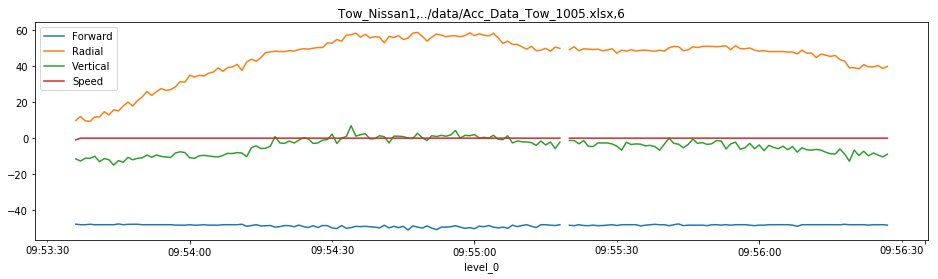

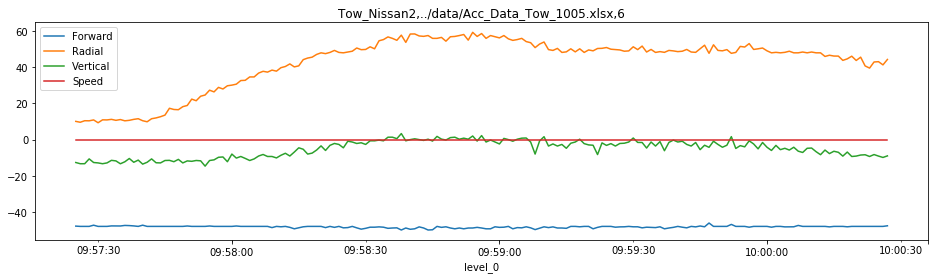

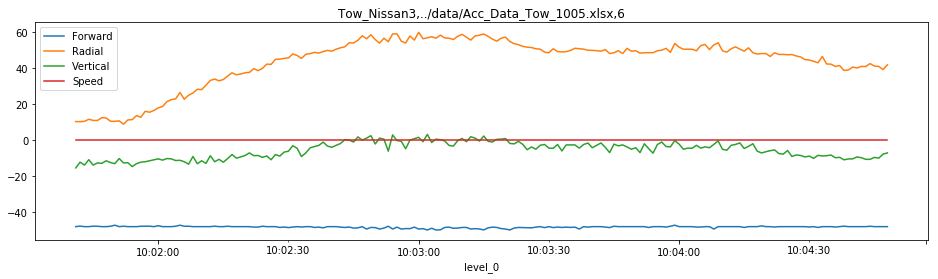

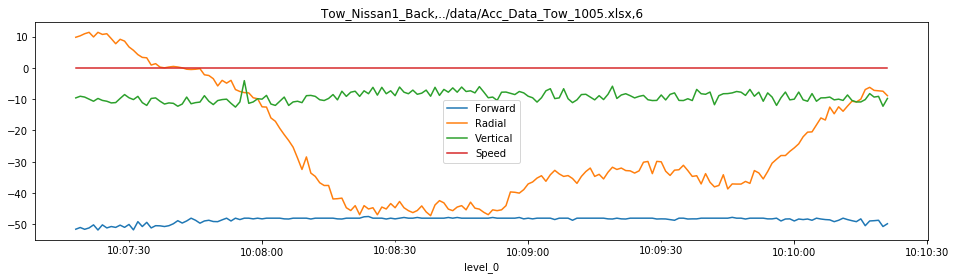

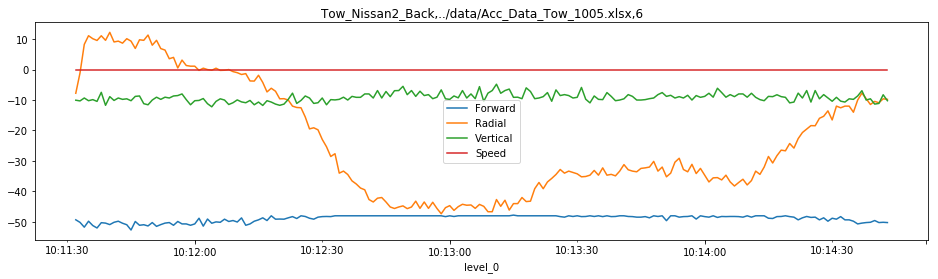

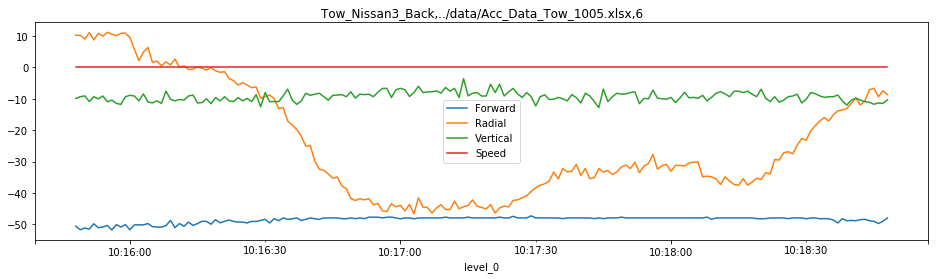

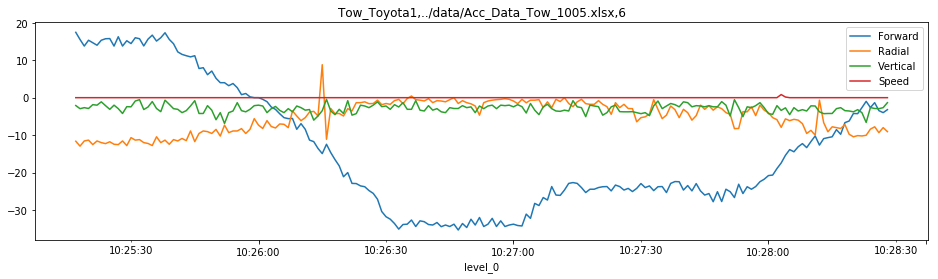

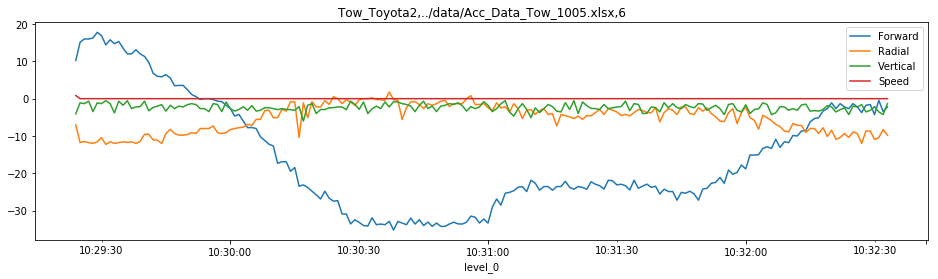

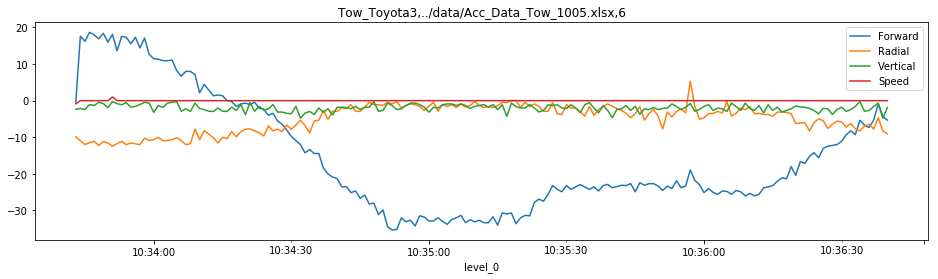

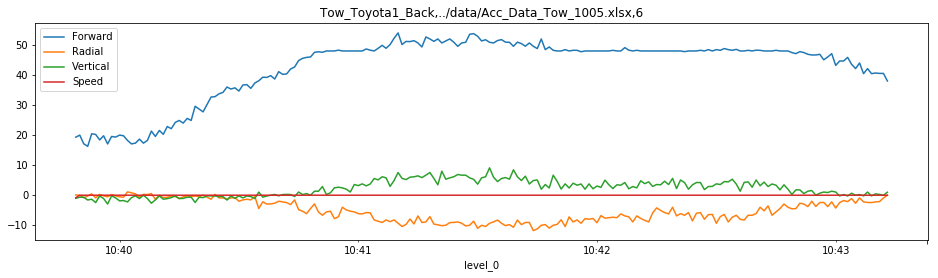

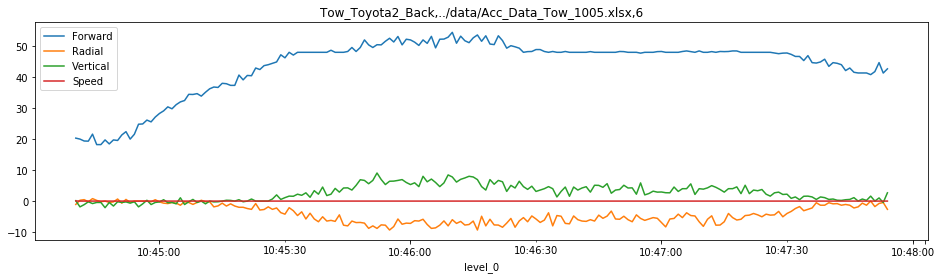

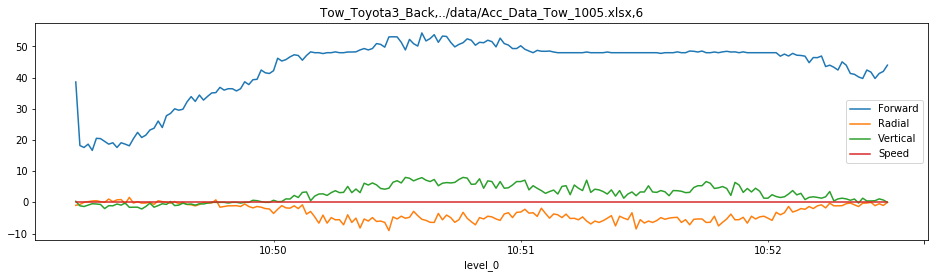

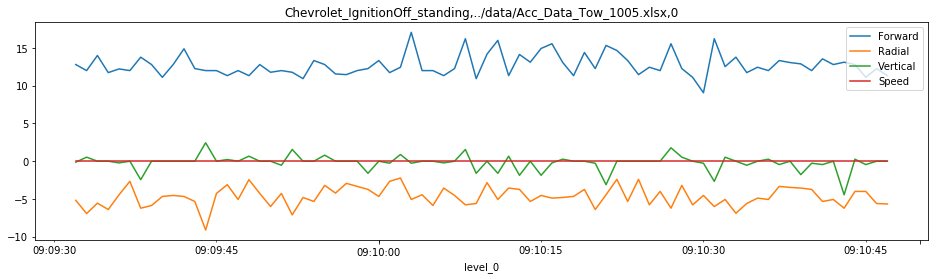

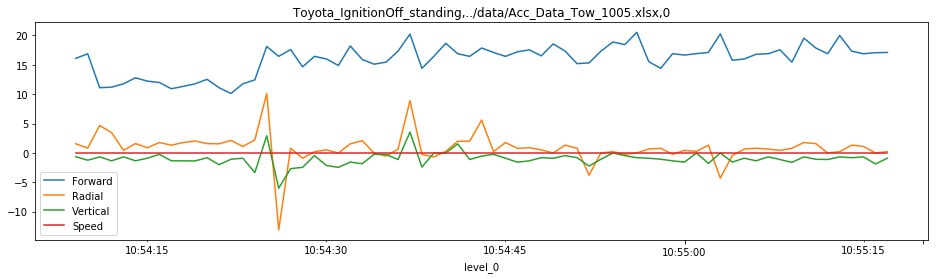

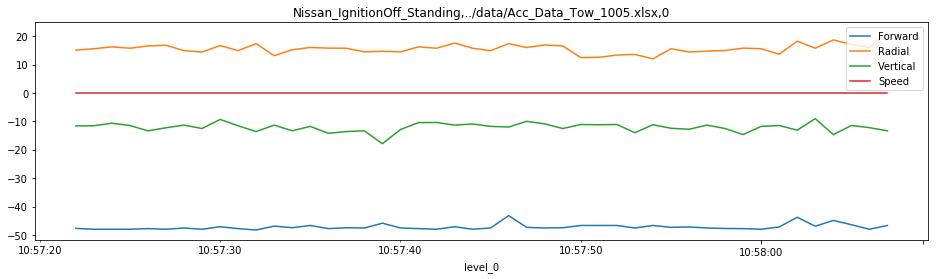

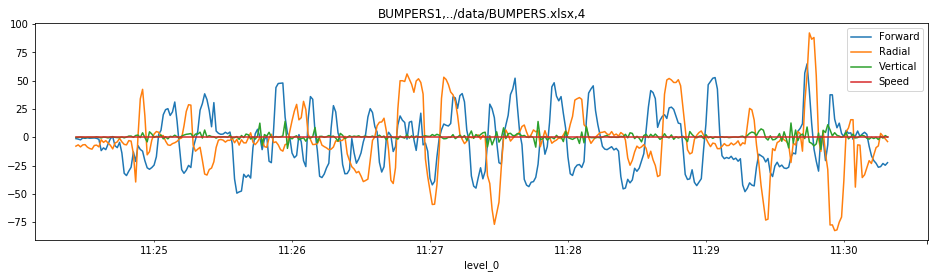

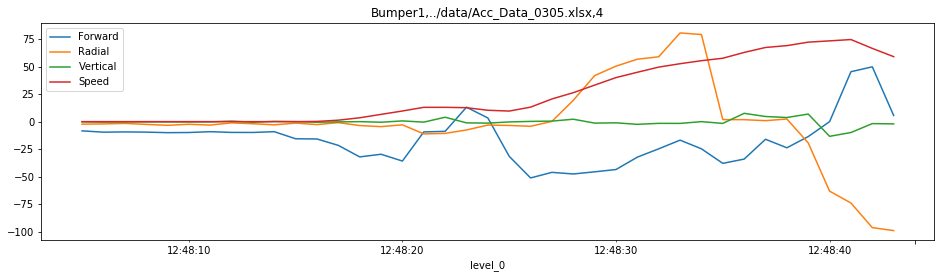

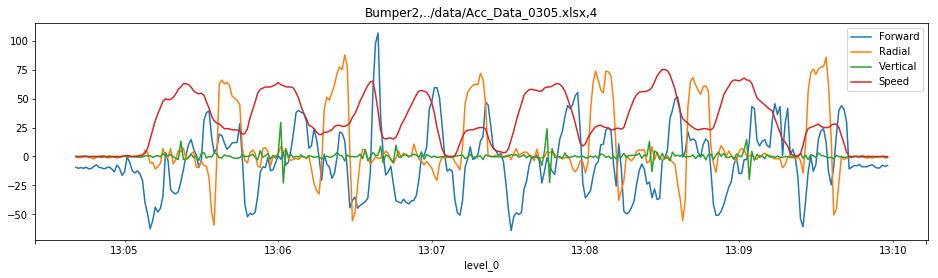

In [5]:
# Load all files error in bumpers file
f=glob.glob('../data/*.xlsx')
e = DataLoader()
e.load_data(f)
big_df=e.big_df

In [91]:
sheet = big_df[(big_df.file=='../data/Acc_Data_Tow_1005.xlsx')&(big_df.sheet=='Tow_Chevrolet1')]

## Some notebook
https://github.com/dolaameng/tutorials/blob/master/timeseries/TS%20-%20SAX%20Symbolic%20Aggregate%20Approximation.ipynb

In [6]:

def znormalization(ts):
    """
    ts - each column of ts is a time series (np.ndarray)
    """
    mus = ts.mean(axis = 0)
    stds = ts.std(axis = 0)
    return (ts - mus) / stds

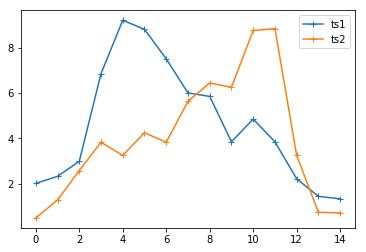

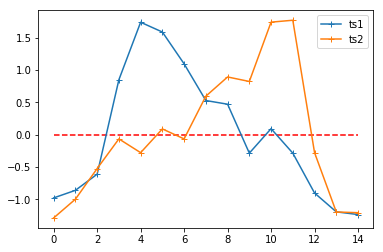

In [7]:
ts1 = np.asarray([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34])
ts2 = np.asarray([0.50, 1.29, 2.58, 3.83, 3.25, 4.25, 3.83, 5.63, 6.44, 6.25, 8.75, 8.83, 3.25, 0.75, 0.72])
ts = pd.DataFrame({"ts1": ts1, "ts2": ts2})
ts.plot(style = "-+")

zts = znormalization(ts)
zts.plot(style = "-+")
plt.hlines(0, 0, 14, colors = 'r', linestyles='--')

### PAA (Piecewise Aggregate Approximation) Description

In [63]:
def paa_transform(ts, n_pieces):
    """
    ts: the columns of which are time series represented by e.g. np.array
    n_pieces: M equally sized piecies into which the original ts is splitted
    """
    splitted = np.array_split(np.array(ts), n_pieces) ## along columns as we want
    a=[]
    for l in splitted:
        a.append([l.mean(axis=0)]*len(l))
        
    return a

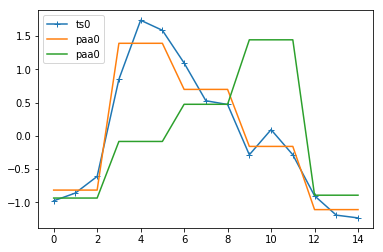

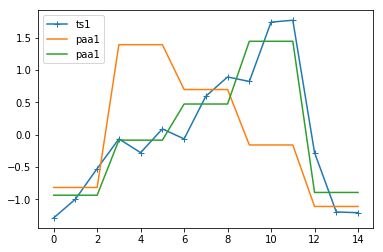

In [64]:

split9 = paa_transform(zts, 5)
split9_ext = np.repeat(split9, 3, axis = 0)
for i in [0, 1]:
    pl.figure()
    pl.plot(zts.iloc[:, i], '-+', label = "ts%i"%i)
    pl.plot(split9_ext[:, i], label = "paa%i"%i)
    pl.legend(loc = "upper left")

In [65]:
def sax_transform(ts, n_pieces, alphabet):
    """
    ts: columns of which are time serieses represented by np.array
    n_pieces: number of segments in paa transformation
    alphabet: the letters to be translated to, e.g. "abcd", "ab"
    return np.array of ts's sax transformation
    Steps:
    1. znormalize
    2. ppa
    3. find norm distribution breakpoints by scipy.stats
    4. convert ppa transformation into strings
    """
    from scipy.stats import norm
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    paa_ts = paa_transform(znormalization(ts), n_pieces)
    return np.apply_along_axis(translate, 0, paa_ts)

In [66]:
sax_transform(ts, 9, "abcd")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## SAX pacakges

In [68]:
from saxpy.alphabet import cuts_for_asize
cuts_for_asize(3)

array([      -inf, -0.4307273,  0.4307273])

In [69]:
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
ts_to_string(znorm(np.array([-2, 0, 2, 0, -1])), cuts_for_asize(3))

'abcba'

In [94]:
ts_to_string(znorm(sheet.Forward), cuts_for_asize(5))

'eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeededeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedeeeeeeeeeeeeeeeeeeeeeeeeeedeeeeeeeeeeeeeeeeeeedeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeededeeee

In [70]:
from saxpy.sax import sax_via_window

dat = np.array([0., 0., 0., 0., 0., -0.270340178359072, -0.367828308500142,
            0.666980581124872, 1.87088147328446, 2.14548907684624,
            -0.480859313143032, -0.72911654245842, -0.490308602315934,
            -0.66152028906509, -0.221049033806403, 0.367003418871239,
            0.631073992586373, 0.0487728723414486, 0.762655178750436,
            0.78574757843331, 0.338239686422963, 0.784206454089066,
            -2.14265084073625, 2.11325193044223, 0.186018356196443,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.519132472499234,
            -2.604783141655, -0.244519550114012, -1.6570790528784,
            3.34184602886343, 2.10361226260999, 1.9796808733979,
            -0.822247322003058, 1.06850578033292, -0.678811824405992,
            0.804225748913681, 0.57363964388698, 0.437113583759113,
            0.437208643628268, 0.989892093383503, 1.76545983424176,
            0.119483882364649, -0.222311941138971, -0.74669456611669,
            -0.0663660879732063, 0., 0., 0., 0., 0.,])

sax1 = sax_via_window(dat, 6, 3, 3, "none", 0.01)

sax1

defaultdict(list,
            {'cca': [0, 1],
             'bbc': [2],
             'bac': [3, 19, 34, 45, 51],
             'aac': [4, 10, 11, 30, 35],
             'acb': [5, 16, 21, 37, 43],
             'bca': [6, 17, 32, 38, 47, 48],
             'cba': [7, 39, 49],
             'caa': [8, 23, 24, 40],
             'cab': [9, 50],
             'abc': [12, 14, 36, 44],
             'acc': [13, 52, 53],
             'bbb': [15, 18, 20, 22, 25, 26, 27, 28, 29, 41, 42, 46],
             'bba': [31],
             'cbb': [33]})

## 5.0 Time series discord discovery with HOT-SAX


In [84]:
# didnt quite get what it does
import numpy as np
from saxpy.hotsax import find_discords_hotsax
from numpy import genfromtxt
dd = genfromtxt("ecg0606_1.csv", delimiter=',')  
discords = find_discords_hotsax(dd,10,10)
discords

[(2168, 1.8205237108747625),
 (1286, 1.6749836247820034),
 (1140, 1.568511413307903),
 (1435, 1.5501291987501606),
 (804, 1.5407480378103648),
 (559, 1.4475140378337192),
 (114, 1.3723043065137326),
 (406, 1.3686261610323083),
 (1092, 1.253905811224549),
 (988, 1.2510321377856877)]

In [88]:
dd[988]

-5.88

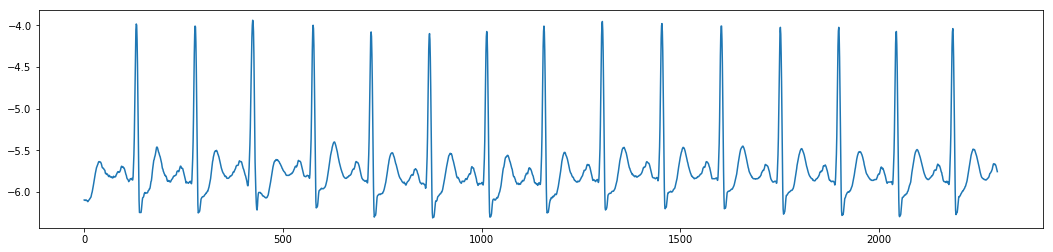

In [81]:
fig,ax= plt.subplots(figsize=(18,4))
ax.plot(dd)

## Sklearn agglomertaive

In [103]:
len(X)

90

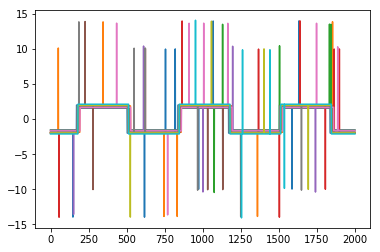

In [107]:
plt.plot(X[0:10].T)

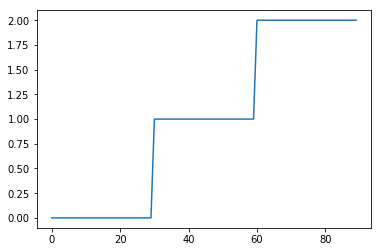

In [102]:
plt.plot(y)

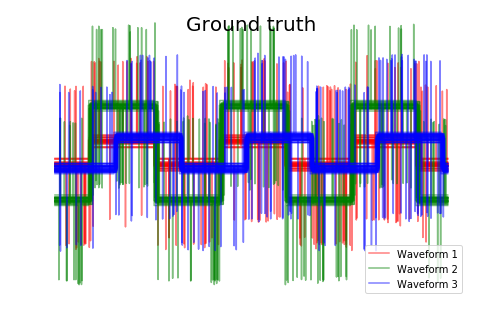

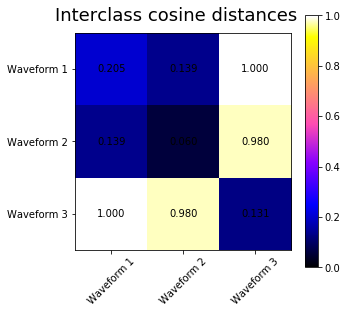

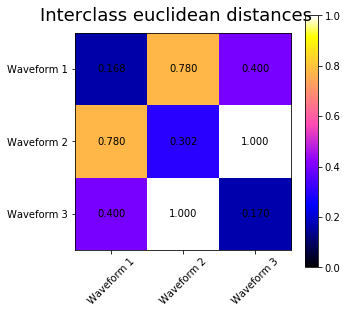

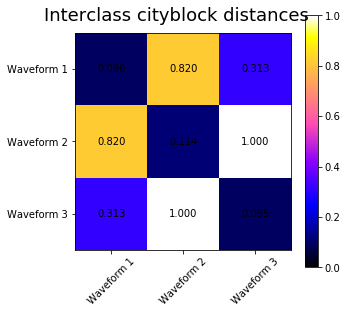

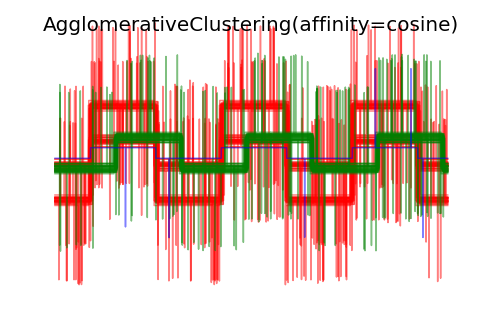

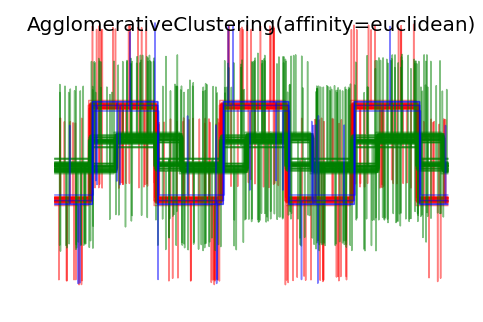

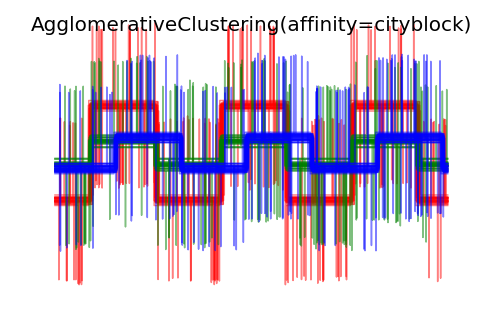

In [95]:
# Author: Gael Varoquaux
# License: BSD 3-Clause or CC-0

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

np.random.seed(0)

# Generate waveform data
n_features = 2000
t = np.pi * np.linspace(0, 1, n_features)


def sqr(x):
    return np.sign(np.cos(x))

X = list()
y = list()
for i, (phi, a) in enumerate([(.5, .15), (.5, .6), (.3, .2)]):
    for _ in range(30):
        phase_noise = .01 * np.random.normal()
        amplitude_noise = .04 * np.random.normal()
        additional_noise = 1 - 2 * np.random.rand(n_features)
        # Make the noise sparse
        additional_noise[np.abs(additional_noise) < .997] = 0

        X.append(12 * ((a + amplitude_noise)
                 * (sqr(6 * (t + phi + phase_noise)))
                 + additional_noise))
        y.append(i)

X = np.array(X)
y = np.array(y)

n_clusters = 3

labels = ('Waveform 1', 'Waveform 2', 'Waveform 3')

# Plot the ground-truth labelling
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c, n in zip(range(n_clusters), 'rgb',
                   labels):
    lines = plt.plot(X[y == l].T, c=c, alpha=.5)
    lines[0].set_label(n)

plt.legend(loc='best')

plt.axis('tight')
plt.axis('off')
plt.suptitle("Ground truth", size=20)


# Plot the distances
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    avg_dist = np.zeros((n_clusters, n_clusters))
    plt.figure(figsize=(5, 4.5))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(X[y == i], X[y == j],
                                                metric=metric).mean()
    avg_dist /= avg_dist.max()
    for i in range(n_clusters):
        for j in range(n_clusters):
            plt.text(i, j, '%5.3f' % avg_dist[i, j],
                     verticalalignment='center',
                     horizontalalignment='center')

    plt.imshow(avg_dist, interpolation='nearest', cmap=plt.cm.gnuplot2,
               vmin=0)
    plt.xticks(range(n_clusters), labels, rotation=45)
    plt.yticks(range(n_clusters), labels)
    plt.colorbar()
    plt.suptitle("Interclass %s distances" % metric, size=18)
    plt.tight_layout()


# Plot clustering results
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    model = AgglomerativeClustering(n_clusters=n_clusters,
                                    linkage="average", affinity=metric)
    model.fit(X)
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
        plt.plot(X[model.labels_ == l].T, c=c, alpha=.5)
    plt.axis('tight')
    plt.axis('off')
    plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)


plt.show()